In [61]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("data_hotel_booking_demand.csv")
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[nan, AGO]"
1,market_segment,object,0,0.00,8,"[Groups, Online TA]"
2,previous_cancellations,int64,0,0.00,15,"[13, 21]"
3,booking_changes,int64,0,0.00,19,"[13, 15]"
4,deposit_type,object,0,0.00,3,"[Non Refund, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[85, 36]"
6,customer_type,object,0,0.00,4,"[Group, Transient]"
7,reserved_room_type,object,0,0.00,10,"[F, C]"
8,required_car_parking_spaces,int64,0,0.00,5,"[3, 1]"
9,total_of_special_requests,int64,0,0.00,6,"[3, 5]"


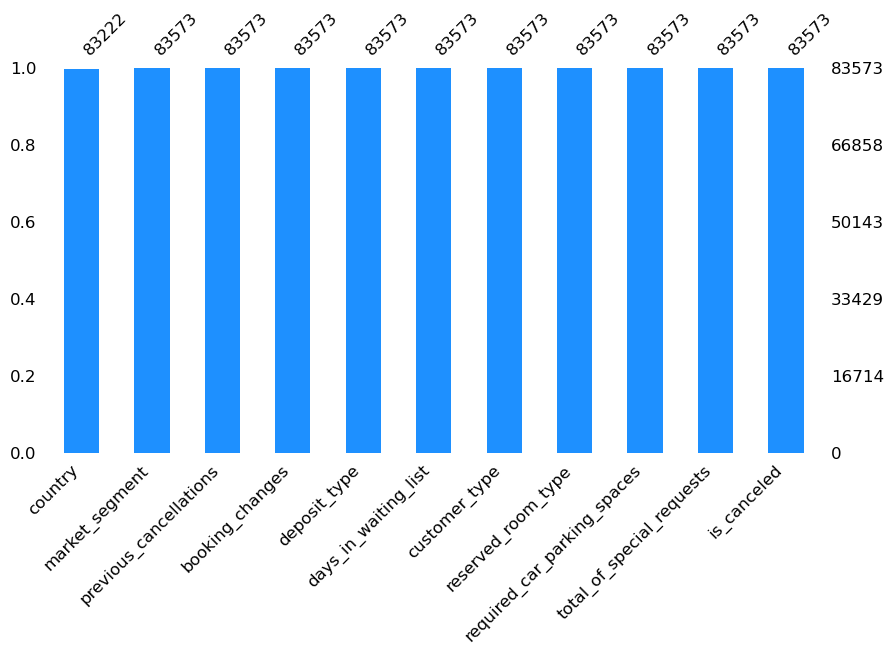

In [5]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

<Axes: >

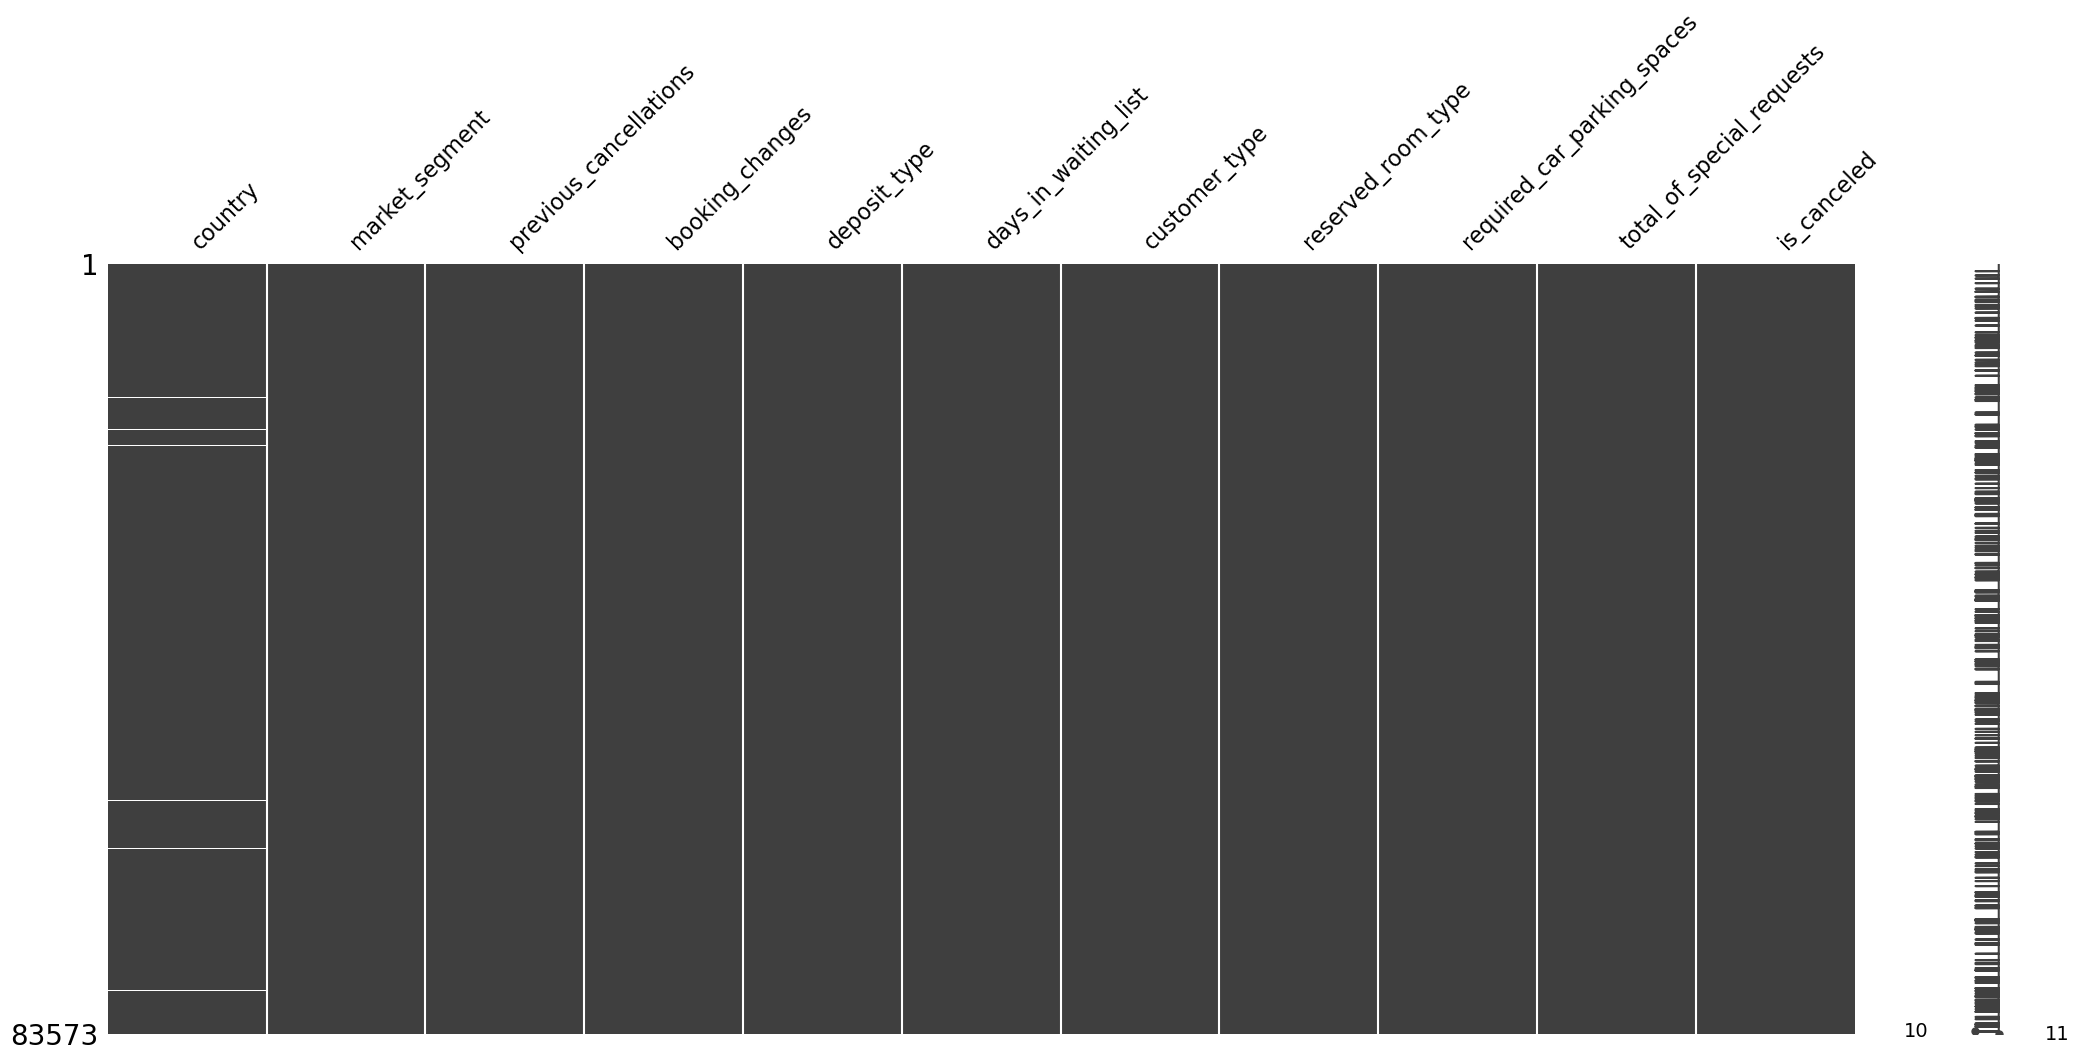

In [6]:
missingno.matrix(df)

In [7]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

In [8]:
df.groupby(['market_segment','previous_cancellations']).count()[['is_canceled']].loc['Complementary']/df.groupby(['market_segment','previous_cancellations']).count()[['is_canceled']].loc['Complementary'].sum()* 100

,is_canceled
previous_cancellations,
0,91.976517
1,2.348337
2,2.935421
3,0.782779
4,1.369863
5,0.587084


In [9]:
df.groupby(['market_segment','previous_cancellations']).count()[['is_canceled']].loc['Direct']

,is_canceled
previous_cancellations,
0,8770
1,116
2,8
3,2
11,1
13,1


In [10]:
df.groupby(['market_segment','previous_cancellations']).count()[['is_canceled']].loc['Direct']/df.groupby(['market_segment','previous_cancellations']).count()[['is_canceled']].loc['Direct'].sum() * 100

,is_canceled
previous_cancellations,
0,98.561474
1,1.303664
2,0.089908
3,0.022477
11,0.011238
13,0.011238


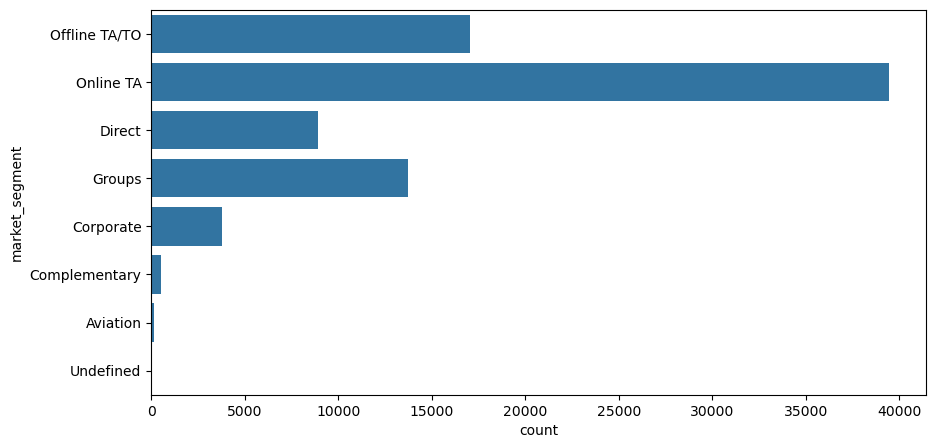

In [11]:
plt.figure(figsize = (10,5))
sns.countplot(df['market_segment'])
plt.show()

In [12]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [13]:
df.describe(include=['O'])

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


Text(0.5, 1.0, 'Day in Waiting List Histogram')

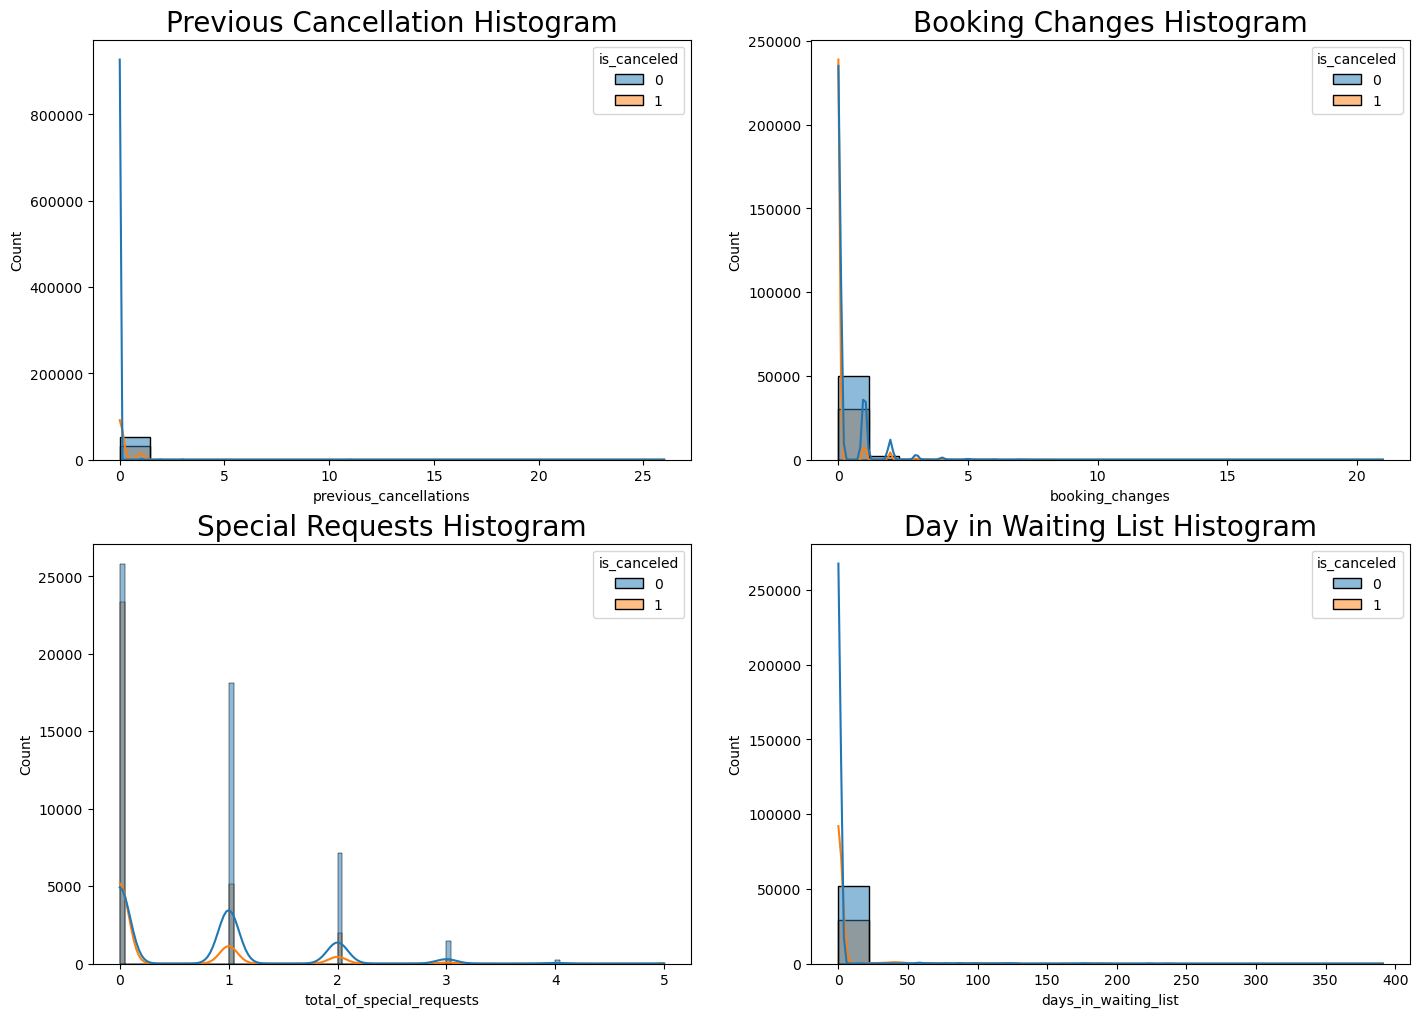

In [15]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df,x='previous_cancellations',hue='is_canceled',kde=True)
plt.title('Previous Cancellation Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(data=df,x='booking_changes',hue='is_canceled',kde=True)
plt.title('Booking Changes Histogram',fontsize=20)

plt.subplot(223)
sns.histplot(data=df,x='total_of_special_requests',hue='is_canceled',kde=True)
plt.title('Special Requests Histogram',fontsize=20)

plt.subplot(224)
sns.histplot(data=df,x='days_in_waiting_list',hue='is_canceled',kde=True)
plt.title('Day in Waiting List Histogram',fontsize=20)

In [ ]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['is_canceled','country','previous_cancellations','booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'required_car_parking_spaces']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [ ]:
for i in df.drop(columns=['is_canceled','country','previous_cancellations','booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'required_car_parking_spaces']).columns:
    relevent_experience_df = df.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=[1.0], ascending=False))

In [ ]:
country_canceled_df = df.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_canceled_df['count'] = df.groupby('country')['is_canceled'].count()
display(country_canceled_df.sort_values(by=[1.0], ascending=False).head(15))
display(country_canceled_df.sort_values(by=[1.0], ascending=False).tail(15))

## Data Preparation

In [29]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Other,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [30]:
imputer_cat = SimpleImputer(strategy='constant', fill_value='N/A')
df['country'] = imputer_cat.fit_transform(df[['country']]).ravel()

In [31]:
# Country Grouping
top_10_countries = df['country'].value_counts().nlargest(10).index
df['country'] = df['country'].apply(lambda x: x if x in top_10_countries else 'Other')

In [62]:
preprocess = ColumnTransformer(
    transformers=[
        ('num_robust', RobustScaler(), ['previous_cancellations', 'booking_changes']),
        ('num_minmax', MinMaxScaler(), ['total_of_special_requests', 'required_car_parking_spaces']),
        ('num_log', Pipeline([
            ('log', FunctionTransformer(np.log1p)), 
            ('scaler', MinMaxScaler())
        ]), ['days_in_waiting_list']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), 
         ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type'])
    ], remainder='passthrough'
)

In [63]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [64]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=2021)

In [36]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [37]:
# Benchmarking K-Fold
models = [logreg,knn,dt,rf,xgb]
score=[]
rata=[]
std=[]
for name in models:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocess), 
        ('model', name)
        ])
    cv_scores = cross_val_score(clf_pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    score.append(cv_scores)
    rata.append(cv_scores.mean())
    std.append(cv_scores.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGB'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
XGB,0.892636,0.001021
Random Forest,0.887915,0.000695
Decision Tree,0.882638,0.000678
Logistic Regression,0.861926,0.002691
KNN,0.848880,0.005553


In [ ]:
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',preprocess),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGB']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression','KNN', 'Decision Tree', 'Random Forest', 'XGB'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

# Test Oversampling with K-Fold Cross Validation

In [ ]:
# Functions
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    

    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [ ]:
# Test Oversampling with k-fold
k = 10
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

data = X_train
target = y_train

train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kfold.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    xgb = XGBClassifier()
    estimator=Pipeline([
        ('preprocess',preprocess),
        ('model',xgb)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

In [ ]:
# Evaluation without oversampling
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

In [ ]:
# Evaluation with Oversampling

listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

In [ ]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

In [ ]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

# Hyperparameter Tuning

In [23]:
xgb = XGBClassifier()

estimator=Pipeline([
    ('preprocess',preprocess),
    ('model',xgb)
])

In [24]:
from scipy.stats import randint, uniform

param_dist = {
    # Learning dynamics
    'model__learning_rate': uniform(0.01, 0.19),      

    # Tree structure
    'model__max_depth': randint(3, 11),               
    'model__min_child_weight': randint(1, 6),         

    # Split regularization
    'model__gamma': uniform(0.0, 0.5),                

    # Stochasticity / subsampling
    'model__subsample': uniform(0.6, 0.4),            
    'model__colsample_bytree': uniform(0.6, 0.4)      #
}

In [41]:
param_dist = {
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}

In [42]:
grid = GridSearchCV(
    estimator, n_jobs=-1, param_grid=param_dist, 
    scoring='roc_auc', 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    )

In [50]:
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_dist,
    n_iter=40,           # 30–50 is a good sweet spot
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [43]:
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 

In [51]:
random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
0.8911874254119908
{'model__random_state': 42, 'model__num_leaves': 21, 'model__num_iterations': 150, 'model__min_data_in_leaf': 20, 'model__max_bin': 255, 'model__learning_rate': 0.125}


In [67]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes']),
                                                 ('num_minmax', MinMaxScaler(),
                                                  ['total_of_special_requests',
                                                   'required_car_parking_spaces']),
                                                 ('num_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['days_in_waiting_l...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.125, max_bin=255,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               min_data_in_leaf=20, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, ...))])

In [66]:
estimator=Pipeline([
    ('preprocess',preprocess),
    ('model',xgb)
])
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes']),
                                                 ('num_minmax', MinMaxScaler(),
                                                  ['total_of_special_requests',
                                                   'required_car_parking_spaces']),
                                                 ('num_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler(...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [58]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default XGB : ', roc_auc_default)
print('ROC AUC Score Tuned XGB : ', roc_auc_tuned)

ROC AUC Score Default XGB :  0.8913017518875497
ROC AUC Score Tuned XGB :  0.8894981083735003


In [57]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGB : \n', report_default)
print('Classification Report Tuned XGB : \n', report_tuned)

Classification Report Default XGB : 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10559
           1       0.77      0.69      0.73      6156

    accuracy                           0.81     16715
   macro avg       0.80      0.79      0.79     16715
weighted avg       0.81      0.81      0.81     16715

Classification Report Tuned XGB : 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10559
           1       0.77      0.69      0.73      6156

    accuracy                           0.81     16715
   macro avg       0.80      0.79      0.79     16715
weighted avg       0.81      0.81      0.81     16715



In [80]:
print('Classification Report Default XGB : \n', report_default)

Classification Report Default XGB : 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     10559
           1       0.77      0.69      0.73      6156

    accuracy                           0.81     16715
   macro avg       0.80      0.79      0.79     16715
weighted avg       0.81      0.81      0.81     16715

